In [13]:
from PYmodule import *
from PYmodule.models_logd import *
import matplotlib
%matplotlib inline

In [14]:
fname = '../M0r8_f2.h5'
prex = '../f2'

labels = [r'$\mathrm{t_{life}}$', r'$\log \delta$', r'$\lambda_0$', r'$\alpha$']

reader = emcee.backends.HDFBackend(fname)
ndim = len(labels)

tau = reader.get_autocorr_time(tol=1)
tau = np.max(tau); print('max tau:',tau)
Nburnin = int(3*tau)
Nthin = int(tau/2)

Nburnin = 0
Nthin = 1

max tau: 249.58268579763228


In [16]:
samples = reader.get_chain(discard=Nburnin)
probs = reader.get_log_prob(discard=Nburnin)
print('len of samples:', len(samples))

samples = reader.get_chain(discard=Nburnin, thin=Nthin, flat=True)
probs = reader.get_log_prob(discard=Nburnin, thin=Nthin, flat=True)
print('len of extracted samples:', len(samples))
theta_max = samples[np.argmax(probs)]
print('best paras:',theta_max,np.max(probs))


len of samples: 5000
len of extracted samples: 500000
best paras: [18.7555167  -1.2574505   0.87372563  0.20389703] -3.1054538991409824


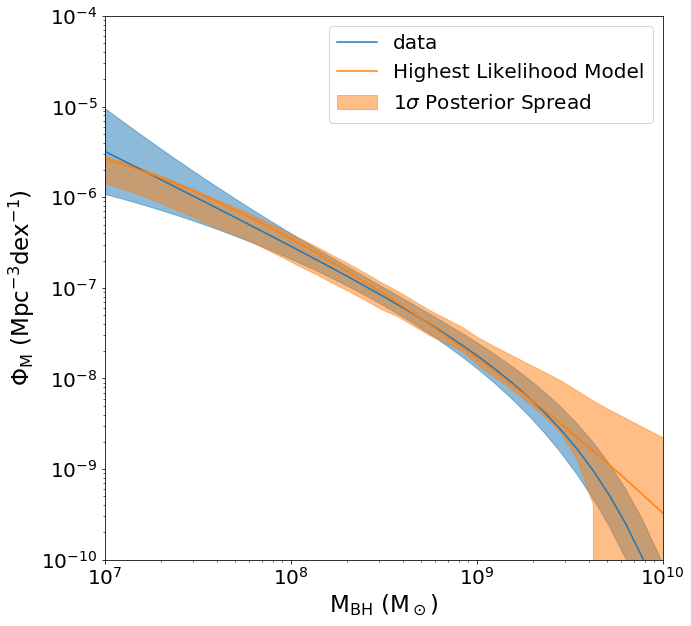

In [5]:
ndraw = 20
fig, ax = plt.subplots(figsize=(10, 10)) #figsize=(10, 10)
curve_name = 'MF'
best_model = model(theta_max)
xs = best_model['M_BH'][::int(N_mf/100)] # ~100 points
y_data = best_model[curve_name+'_data'][::int(N_mf/100)]
y_logdata = np.log10(y_data)
y_best = best_model[curve_name][::int(N_mf/100)]
y_err = best_model[curve_name+'_data_err'][::int(N_mf/100)]
ax.plot(xs, y_data, c='C0',label='W10')
# error band of W10
plt.fill_between(xs,pow(10.,y_logdata-y_err/2.),pow(10.,y_logdata+y_err/2.),color='C0',alpha=0.5,label='_')

draw = np.floor(np.random.uniform(0,len(samples),size=ndraw)).astype(int)
thetas = samples[draw]
model_thetas = [model(theta_i) for theta_i in thetas]
mod_list = []
for i in range(ndraw):
    mod = model_thetas[i][curve_name][::int(N_mf/100)]
    mod_list.append(mod)
    # ax.plot(xs, mod, c='grey',label='_',alpha=.2)
spread = np.std(mod_list,axis=0)
med_model = np.median(mod_list,axis=0)
plt.fill_between(xs,med_model-spread,med_model+spread,color='orange',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
ax.plot(xs, y_best, c='orange', label='Highest Likelihood Model')
ax.set_xlim(1e7,1e10); ax.set_xscale('log')
ax.set_ylim(1e-10,1e-4); ax.set_yscale('log')
ax.legend(fontsize=fslegend)

plt.xlabel(r'$\mathrm{M_{BH}~(M_\odot)}$',fontsize=fslabel)
plt.ylabel(r'$\mathrm{\Phi_M~(Mpc^{-3}dex^{-1})}$',fontsize=fslabel)
plt.tick_params(labelsize=fstick)
plt.savefig(prex+'ndraw%dMF_spread.png'%ndraw,dpi=300,bbox_inches='tight')
# plt.show()

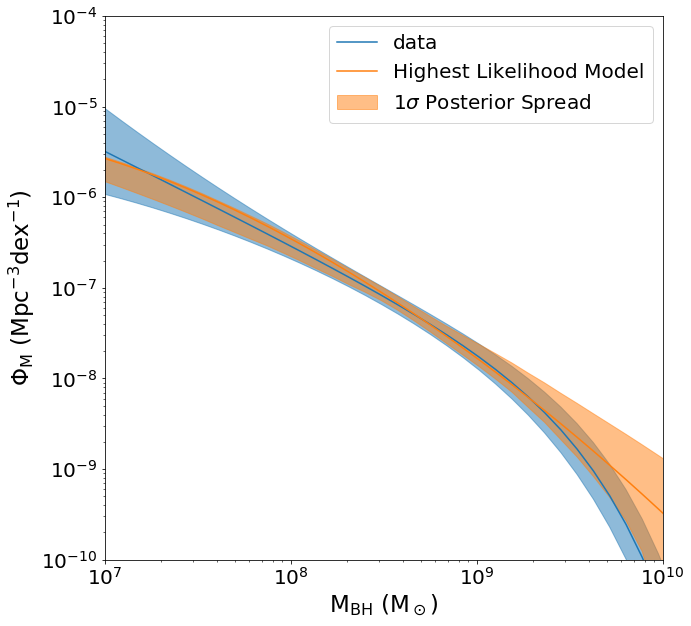

In [6]:
ndraw = 40
fig, ax = plt.subplots(figsize=(10, 10)) #figsize=(10, 10)
curve_name = 'MF'
best_model = model(theta_max)
xs = best_model['M_BH'][::int(N_mf/100)] # ~100 points
y_data = best_model[curve_name+'_data'][::int(N_mf/100)]
y_logdata = np.log10(y_data)
y_best = best_model[curve_name][::int(N_mf/100)]
y_err = best_model[curve_name+'_data_err'][::int(N_mf/100)]
ax.plot(xs, y_data, c='C0',label='data')
# error band of W10
plt.fill_between(xs,pow(10.,y_logdata-y_err/2.),pow(10.,y_logdata+y_err/2.),color='C0',alpha=0.5,label='_')

draw = np.floor(np.random.uniform(0,len(samples),size=ndraw)).astype(int)
thetas = samples[draw]
model_thetas = [model(theta_i) for theta_i in thetas]
mod_list = []
for i in range(ndraw):
    mod = model_thetas[i][curve_name][::int(N_mf/100)]
    mod_list.append(mod)
    # ax.plot(xs, mod, c='grey',label='_',alpha=.2)
spread = np.std(mod_list,axis=0)
med_model = np.median(mod_list,axis=0)
plt.fill_between(xs,med_model-spread,med_model+spread,color='orange',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
ax.plot(xs, y_best, c='orange', label='Highest Likelihood Model')
ax.set_xlim(1e7,1e10); ax.set_xscale('log')
ax.set_ylim(1e-10,1e-4); ax.set_yscale('log')
ax.legend(fontsize=fslegend)

plt.xlabel(r'$\mathrm{M_{BH}~(M_\odot)}$',fontsize=fslabel)
plt.ylabel(r'$\mathrm{\Phi_M~(Mpc^{-3}dex^{-1})}$',fontsize=fslabel)
plt.tick_params(labelsize=fstick)
plt.savefig(prex+'ndraw%dMF_spread.png'%ndraw,dpi=300,bbox_inches='tight')
# plt.show()

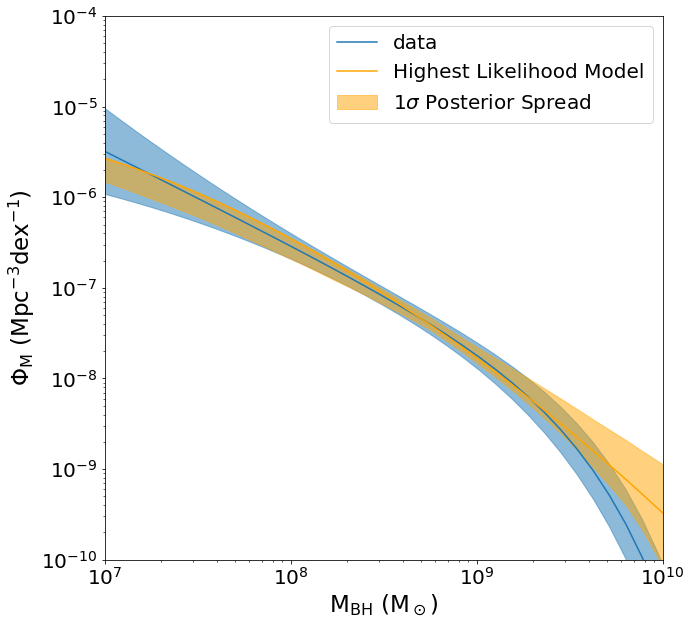

In [17]:
ndraw = 60
fig, ax = plt.subplots(figsize=(10, 10)) #figsize=(10, 10)
curve_name = 'MF'
best_model = model(theta_max)
xs = best_model['M_BH'][::int(N_mf/100)] # ~100 points
y_data = best_model[curve_name+'_data'][::int(N_mf/100)]
y_logdata = np.log10(y_data)
y_best = best_model[curve_name][::int(N_mf/100)]
y_err = best_model[curve_name+'_data_err'][::int(N_mf/100)]
ax.plot(xs, y_data, c='C0',label='data')
# error band of W10
plt.fill_between(xs,pow(10.,y_logdata-y_err/2.),pow(10.,y_logdata+y_err/2.),color='C0',alpha=0.5,label='_')

draw = np.floor(np.random.uniform(0,len(samples),size=ndraw)).astype(int)
thetas = samples[draw]
model_thetas = [model(theta_i) for theta_i in thetas]
mod_list = []
for i in range(ndraw):
    mod = model_thetas[i][curve_name][::int(N_mf/100)]
    mod_list.append(mod)
    # ax.plot(xs, mod, c='grey',label='_',alpha=.2)
spread = np.std(mod_list,axis=0)
med_model = np.median(mod_list,axis=0)
plt.fill_between(xs,med_model-spread,med_model+spread,color='orange',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
ax.plot(xs, y_best, c='orange', label='Highest Likelihood Model')
ax.set_xlim(1e7,1e10); ax.set_xscale('log')
ax.set_ylim(1e-10,1e-4); ax.set_yscale('log')
ax.legend(fontsize=fslegend)

plt.xlabel(r'$\mathrm{M_{BH}~(M_\odot)}$',fontsize=fslabel)
plt.ylabel(r'$\mathrm{\Phi_M~(Mpc^{-3}dex^{-1})}$',fontsize=fslabel)
plt.tick_params(labelsize=fstick)
plt.savefig(prex+'ndraw%dMF_spread.png'%ndraw,dpi=300,bbox_inches='tight')
# plt.show()

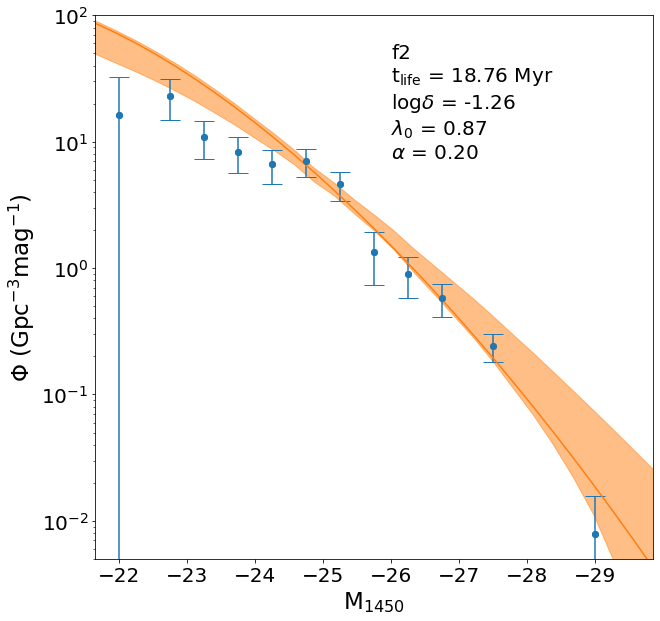

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
curve_name = 'LF'
xs = best_model['M1450']
x_data = best_model['M1450_data']
y_data = best_model[curve_name+'_data']
y_data_err = best_model[curve_name+'_data_err']
y_best = best_model[curve_name]
ax.scatter(x_data, y_data, label='_')
plt.errorbar(x_data, y_data, yerr=y_data_err,fmt='o',capsize=10)
# print('y_data_err',y_data_err)
mod_list = []
for i in range(ndraw):
    mod = model_thetas[i][curve_name]
    mod_list.append(mod)
    # ax.plot(xs, mod, c='grey',label='_',alpha=.2)
spread = np.std(mod_list,axis=0)
med_model = np.median(mod_list,axis=0)
plt.fill_between(xs,med_model-spread,med_model+spread,color='orange',alpha=0.5,label='_')
ax.plot(xs, y_best, c='orange', label='_')
ax.text(-26,5, 'f2\n'+ \
labels[0]+' = %.2f Myr\n'%(theta_max[0])+labels[1]+' = %.2f\n'%(theta_max[1])\
+labels[2]+' = %.2f\n'%(theta_max[2])+labels[3]+' = %.2f\n'%(theta_max[3])
, fontsize=20)
ax.set_xlim(np.max(xs),np.min(xs))
ax.set_ylim(5e-3,1e2)
ax.set_yscale('log')
plt.xlabel(r'$\mathrm{M_{1450}}$',fontsize=fslabel)
plt.ylabel(r'$\mathrm{\Phi~(Gpc^{-3}mag^{-1})}$',fontsize=fslabel)
plt.tick_params(labelsize=fstick)
# plt.tight_layout()
plt.savefig(prex+'ndraw%dLF_spread.png'%ndraw,dpi=300,bbox_inches='tight')


In [10]:
print(ndraw)

40
